In [1]:
directory='/Users/julnow/gsi/cbm/ML/JupyterNotebooks/'
sign_27 = directory+'img/xgb_3.3gev/27.5mf/'+'signal.feather'
all_27 = directory+'img/xgb_3.3gev/27.5mf/'+'all.feather'
sign_56 = directory+'img/xgb_3.3gev/56mf/'+'signal.feather'
all_56 = directory+'img/xgb_3.3gev/56mf/'+'all.feather'
sign_100 =directory+'img/xgb_12agev/100mf/'+'signal.feather'
all_100 = directory+'img/xgb_12agev/100mf/'+'all.feather'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from CBM_ML import tree_importer,  KFPF_lambda_cuts, plot_tools
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

import gc, os
import feather

In [4]:
sign27 = pd.read_feather(sign_27)
all27 = pd.read_feather(all_27)
sign56 = pd.read_feather(sign_56)
all56 = pd.read_feather(all_56)
sign100 = pd.read_feather(sign_100)
all100 = pd.read_feather(all_100)

In [74]:
bins1 = 200
range1 = (0.279, 1)
counts, bin_edges = np.histogram(all27['mass'],bins = bins1, range=range1)

In [76]:
counts*10

array([ 622050,  827460, 1107460, 1307850, 1454600, 1567140, 1657630,
       1730530, 1775040, 1807840, 1829700, 1862480, 1868920, 1881560,
       1871320, 1863340, 1860800, 1844080, 1834070, 1817660, 1795380,
       1774340, 1748410, 1721040, 1693930, 1663950, 1643050, 1610860,
       1573930, 1540510, 1508090, 1483340, 1446970, 1409450, 1384980,
       1348710, 1311660, 1285550, 1260890, 1229280, 1201000, 1168780,
       1130920, 1107780, 1078810, 1055870, 1022890, 1001410,  971340,
        949450,  921100,  891630,  871320,  841870,  823860,  799800,
        772420,  754900,  734020,  713230,  697540,  675940,  658020,
        634170,  614450,  596120,  579560,  556260,  547180,  529390,
        516380,  496600,  486070,  468080,  455290,  446380,  429690,
        420290,  400710,  391710,  384250,  367490,  359910,  351180,
        339220,  323810,  319730,  308560,  299960,  293540,  282220,
        276280,  264770,  259170,  250760,  243060,  235880,  228590,
        223130,  216

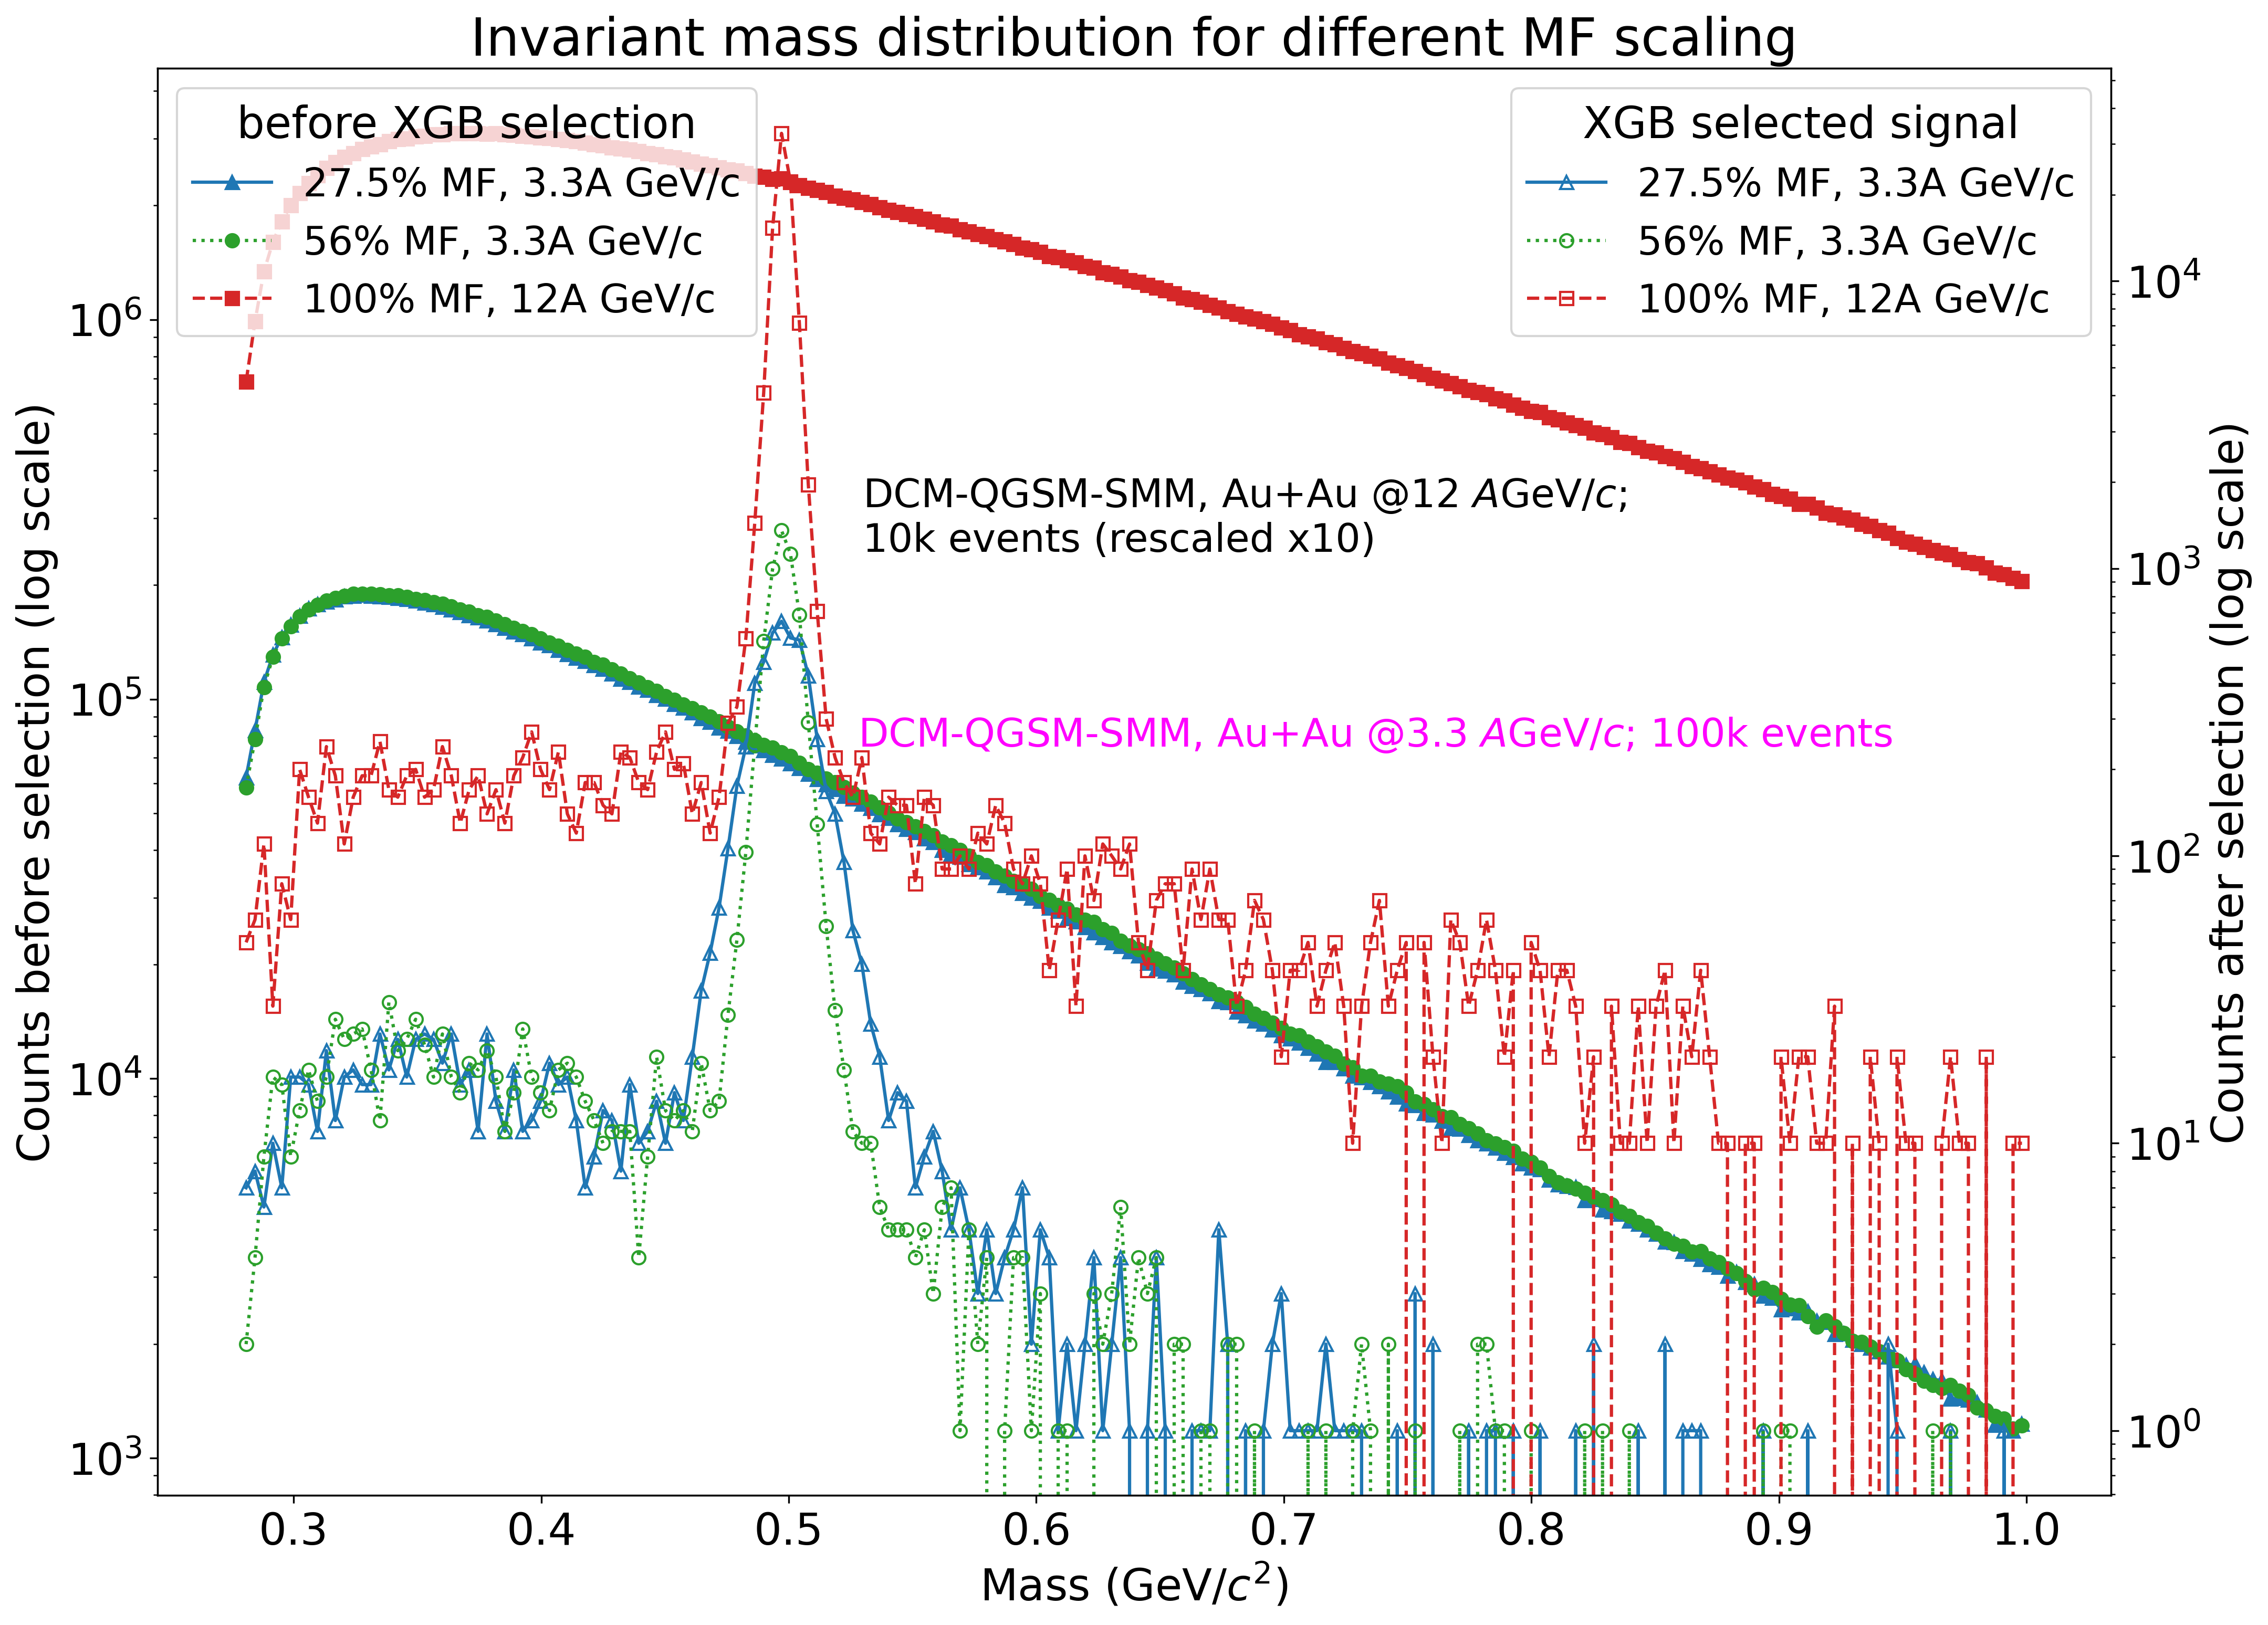

In [96]:
bins1 = 200
range1 = (0.279, 1)
fig, ax2 = plt.subplots(figsize=(16, 12), dpi = 300)
ax2.set_ylabel('Counts before selection (log scale)', fontsize = 20, color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 20)

ax1 = ax2.twinx()
ax1.set_xlabel('Mass in GeV', fontsize = 24)
ax1.set_ylabel('Counts after selection (log scale)', fontsize = 20, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='both', which='major', labelsize=20)


def subplot(al, sign, marker, linestyle, label, color, scale=False):
    counts, bin_edges = np.histogram(al['mass'],bins = bins1, range=range1)
    if scale!=False:
        counts = 10*counts
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax2.plot(bin_centers, counts, color=color, linestyle=linestyle, marker=marker, label=label)
    
    counts, bin_edges = np.histogram(sign['mass'],bins = 200, range=range1)
    if scale!=False:
        counts = 10*counts
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax1.plot(bin_centers, counts, color=color, linestyle=linestyle, marker=marker, label=label, markerfacecolor='none')

subplot(all27, sign27, marker='^', linestyle='solid', label='27.5% MF, 3.3A GeV/c', color = 'tab:blue')
subplot(all56, sign56, marker='o', linestyle='dotted', label='56% MF, 3.3A GeV/c', color =  'tab:green')
subplot(all100, sign100, marker='s', linestyle='dashed', label='100% MF, 12A GeV/c', color = 'tab:red', scale=True)

ax2.legend(title= 'before XGB selection', fontsize = 18, loc='upper left')
ax1.legend(title= 'XGB selected signal',fontsize = 18,loc='upper right' )
ax2.text(0.53, 245000, r'DCM-QGSM-SMM, Au+Au @12 $A$GeV/$c$;' '\n10k events (rescaled x10)', fontsize=18, color = 'black')
ax2.text(0.528, 75000, r'DCM-QGSM-SMM, Au+Au @3.3 $A$GeV/$c$; 100k events', fontsize=18, color = 'magenta')
plt.title("Invariant mass distribution for different MF scaling", fontsize = 24)
plt.rcParams['legend.title_fontsize'] = 20
ax2.set_yscale('log')
ax1.set_yscale('log')
#plt.text(0.02, 0.1, r'cut > %.4f'%cut, fontsize=15)
plt.show()
fig.tight_layout()
fig.savefig(directory+'img/mf0log.pdf')
fig.savefig(directory+'img/mf0log.png')

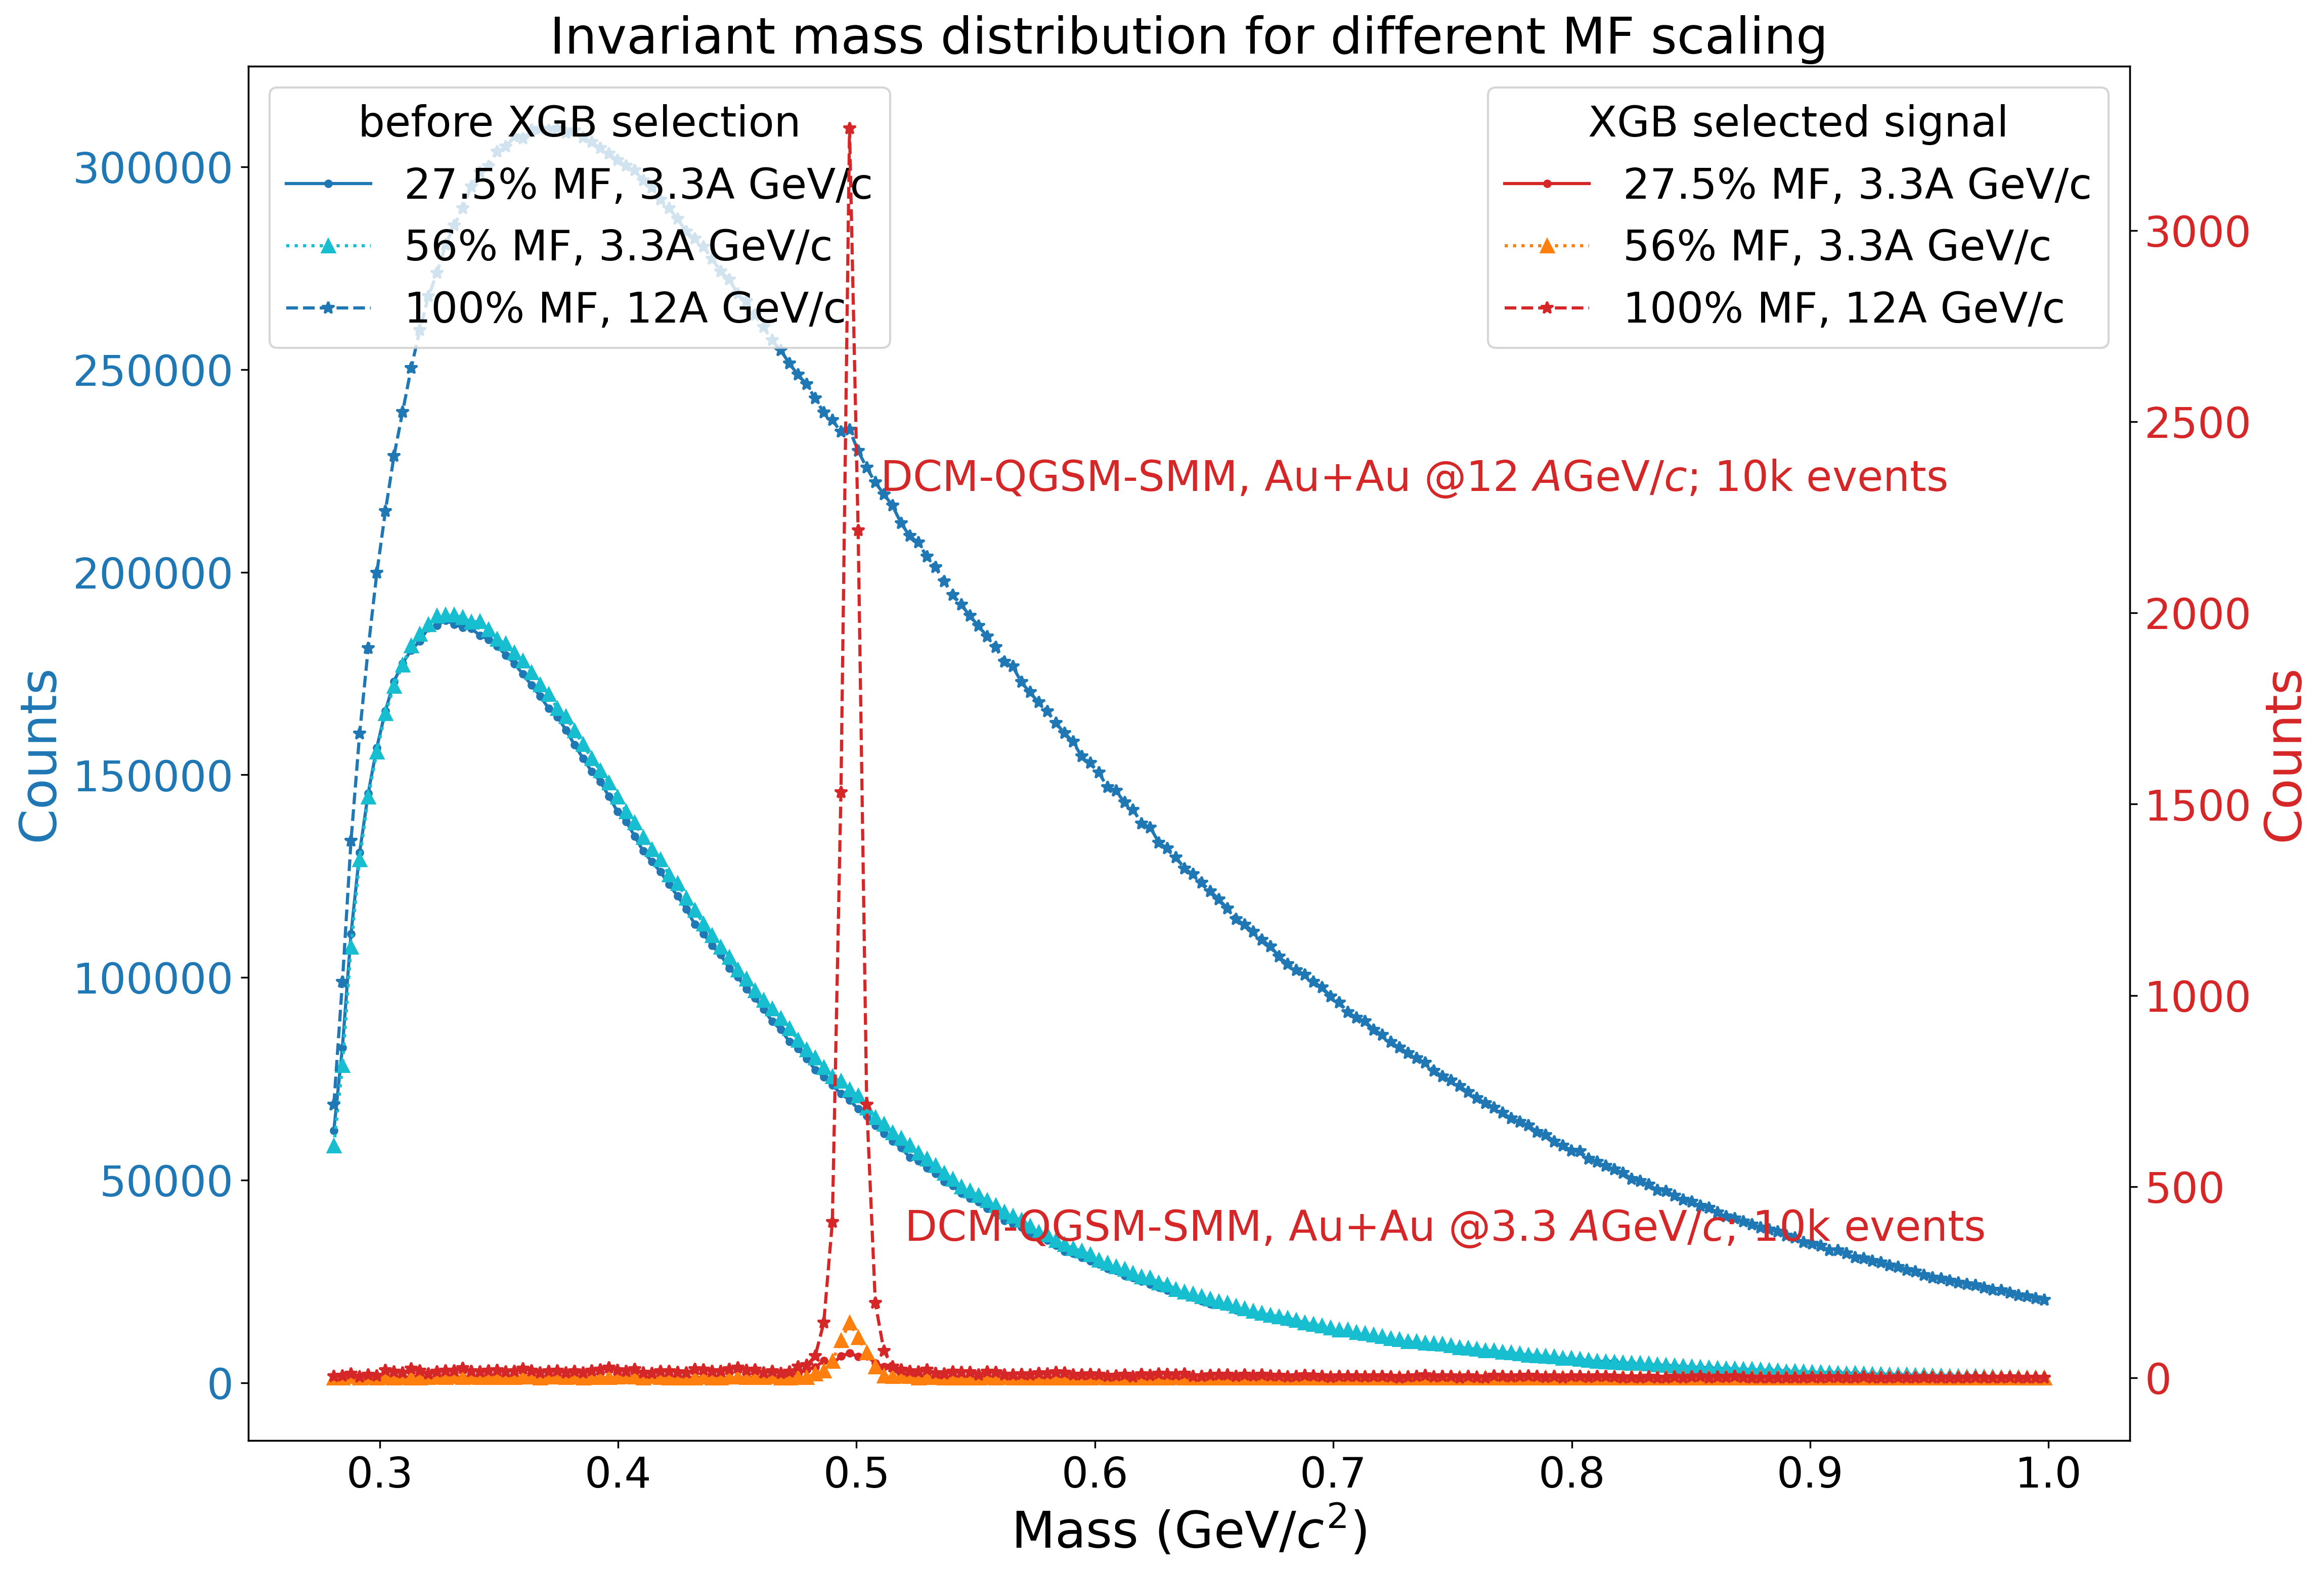

In [66]:
bins1 = 200
range1 = (0.279, 1)
fig, ax2 = plt.subplots(figsize=(16, 12), dpi = 300)
ax2.set_ylabel('Counts ', fontsize = 24, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 24)

ax1 = ax2.twinx()
ax1.set_xlabel('Mass in GeV', fontsize = 20)
ax1.set_ylabel('Counts', fontsize = 24, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.tick_params(axis='both', which='major', labelsize=20)


def subplot(al, sign, marker, linestyle, label, color, color2):
    counts, bin_edges = np.histogram(al['mass'],bins = bins1, range=range1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax2.plot(bin_centers, counts, color=color, linestyle=linestyle, marker=marker, label=label)
    
    counts, bin_edges = np.histogram(sign['mass'],bins = 200, range=range1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax1.plot(bin_centers, counts, color=color2, linestyle=linestyle, marker=marker, label=label)

subplot(all27, sign27.sample(frac=0.1), marker='.', linestyle='solid', label='27.5% MF, 3.3A GeV/c', color = 'tab:blue', color2 = 'tab:red')
subplot(all56, sign56.sample(frac=0.1), marker='^', linestyle='dotted', label='56% MF, 3.3A GeV/c', color = 'tab:cyan', color2 = 'tab:orange')
subplot(all100, sign100, marker='*', linestyle='dashed', label='100% MF, 12A GeV/c', color = 'tab:blue', color2 = 'tab:red')

ax2.legend(title= 'before XGB selection', fontsize = 20, loc='upper left')
ax1.legend(title= 'XGB selected signal',fontsize = 20,loc='upper right' )
ax2.text(0.51, 220000, r'DCM-QGSM-SMM, Au+Au @12 $A$GeV/$c$; 10k events', fontsize=20, color = 'tab:red')
ax2.text(0.52, 35000, r'DCM-QGSM-SMM, Au+Au @3.3 $A$GeV/$c$; 10k events', fontsize=20, color = 'tab:red')
plt.title("Invariant mass distribution for different MF scaling", fontsize = 24)
plt.rcParams['legend.title_fontsize'] = 20
# ax2.set_yscale('log')
# ax1.set_yscale('log')
#plt.text(0.02, 0.1, r'cut > %.4f'%cut, fontsize=15)
plt.show()
fig.tight_layout()
fig.savefig(directory+'img/mf0.pdf')
fig.savefig(directory+'img/mf0.png')

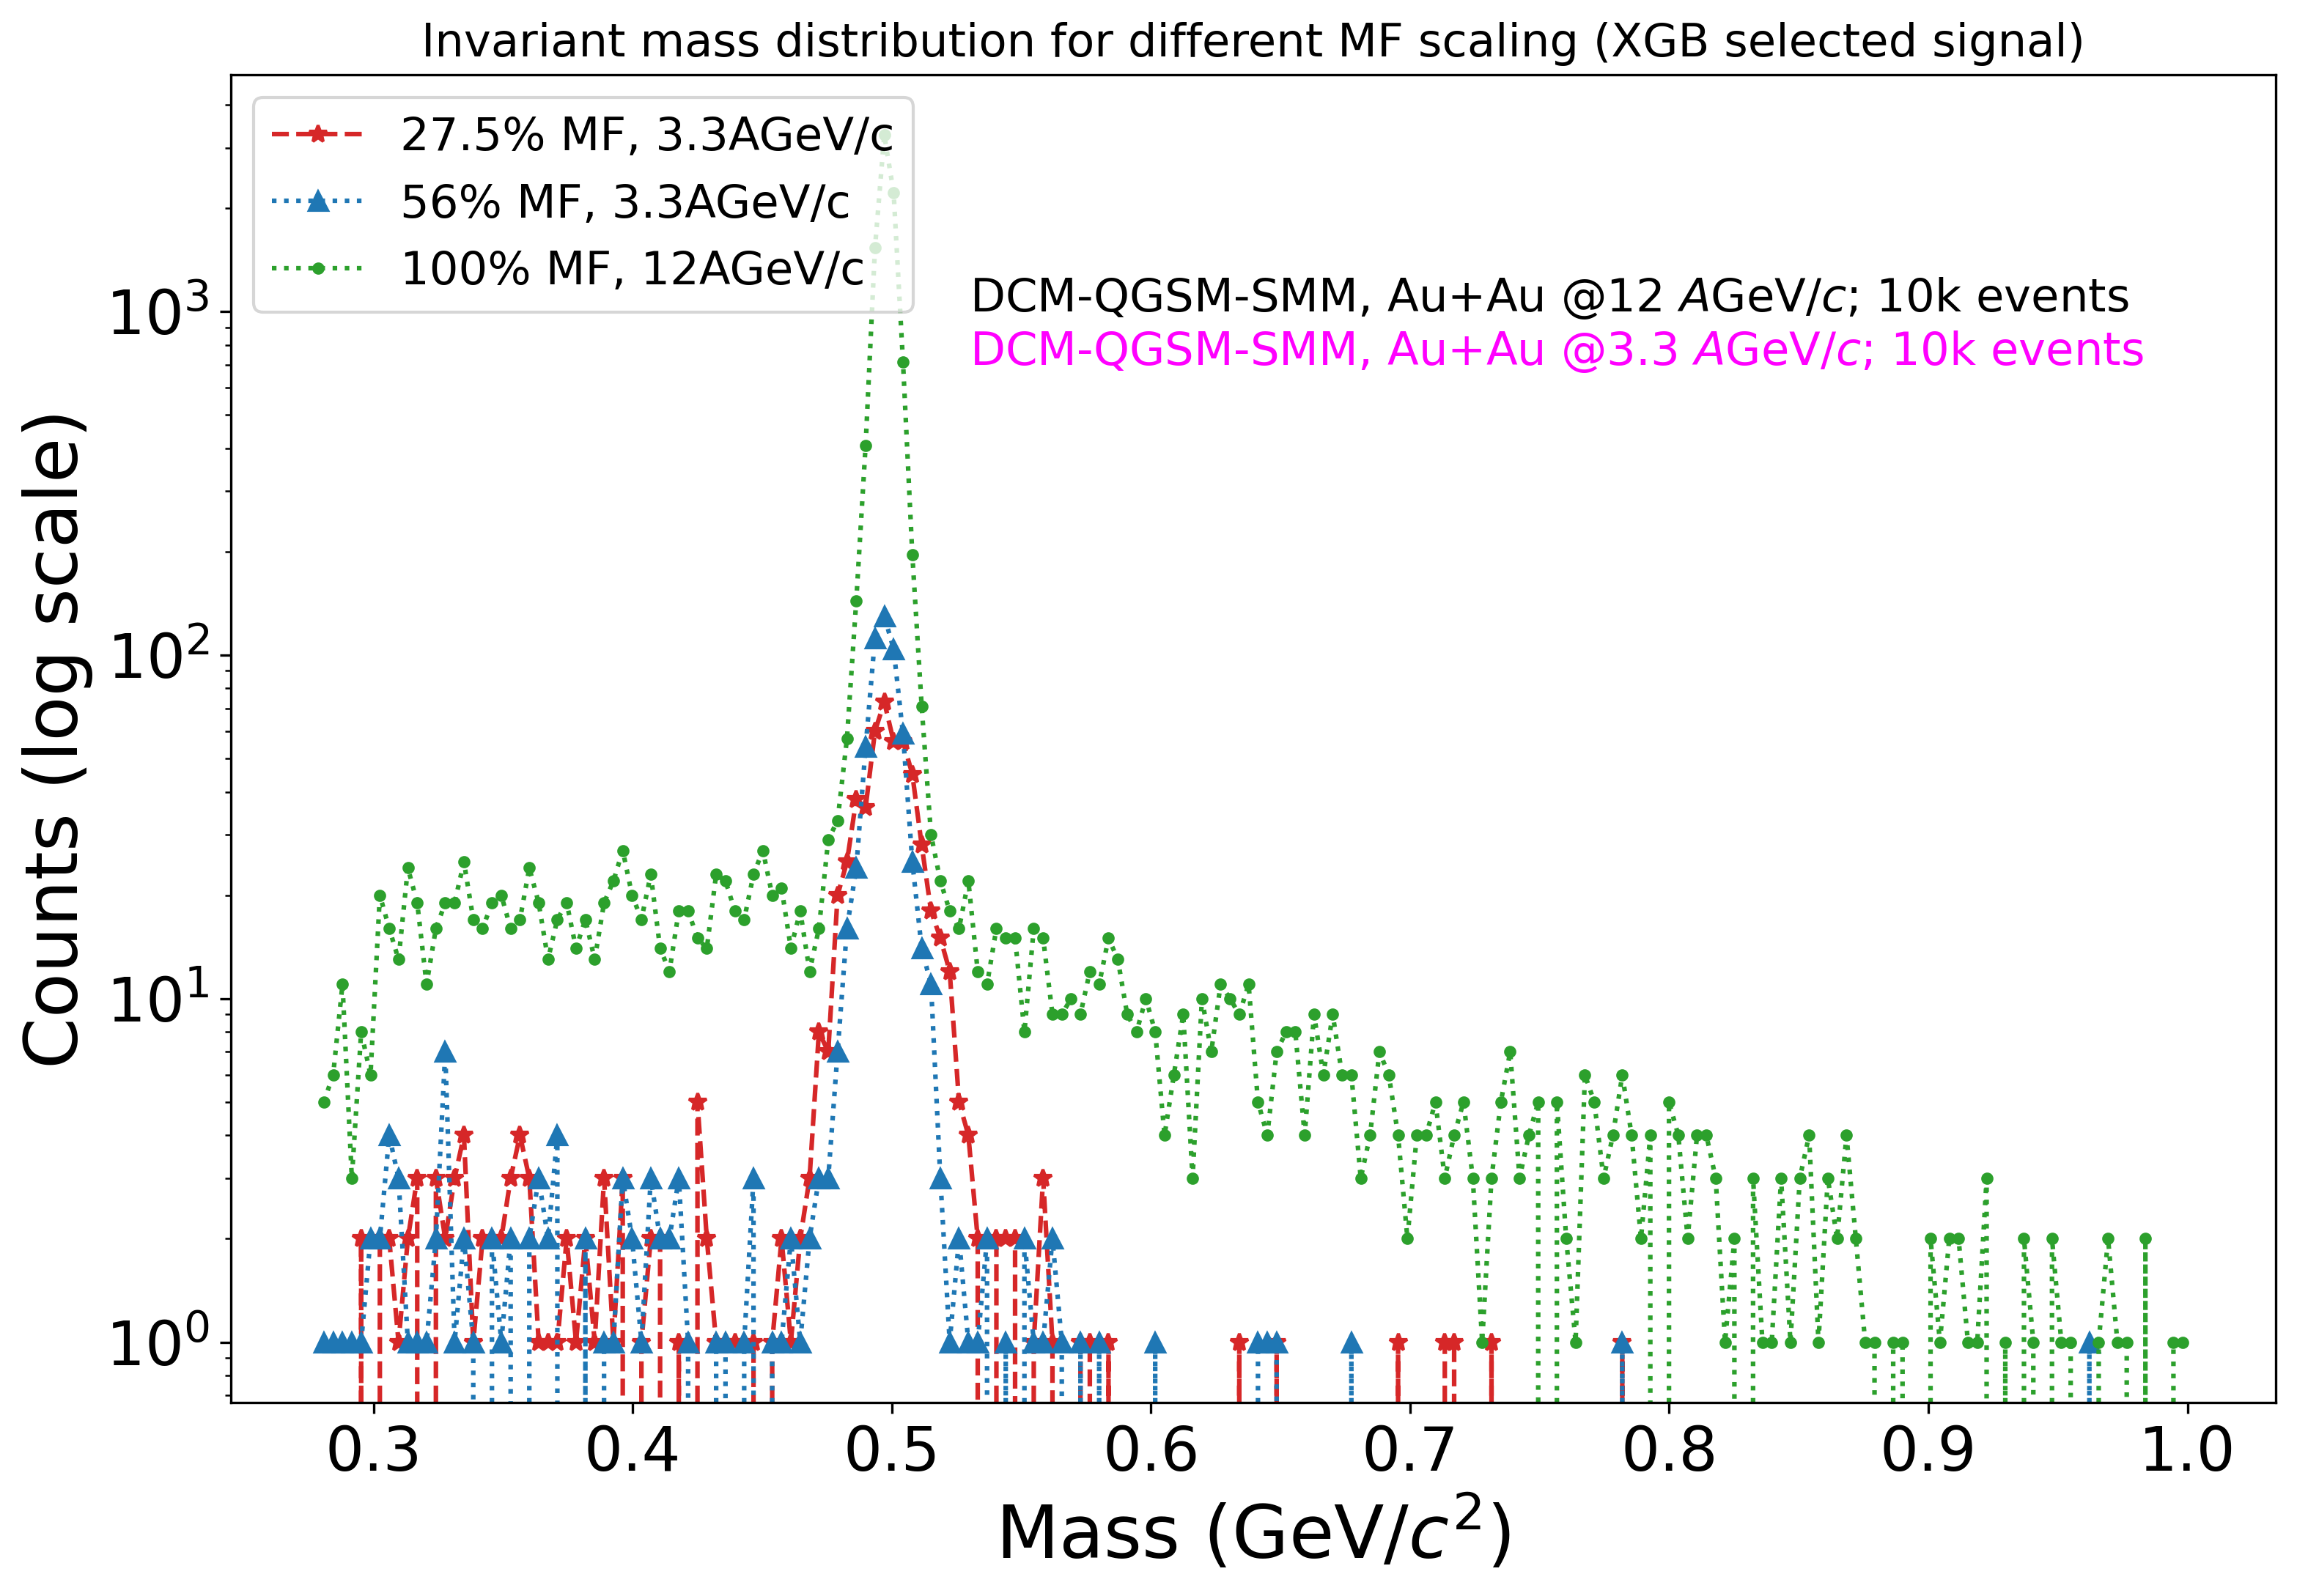

In [56]:
bins1 = 200
range1 = (0.279, 1)
fig, ax2 = plt.subplots(figsize=(12, 8), dpi = 300)
ax2.set_ylabel('Counts (log scale)', fontsize = 24, color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 24)

# ax1 = ax2.twinx()
# ax1.set_xlabel('Mass in GeV', fontsize = 15)
# ax1.set_ylabel('Counts ', fontsize = 15, color=color2)
# ax1.tick_params(axis='y', labelcolor=color2)


def subplot(al, sign, marker, linestyle, label, color, color2):
#     counts, bin_edges = np.histogram(al['mass'],bins = bins1, range=range1)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#     ax2.plot(bin_centers, counts, color=color, linestyle=linestyle, marker=marker, label=label)
    
    counts, bin_edges = np.histogram(sign['mass'],bins = 200, range=range1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax2.plot(bin_centers, counts, color=color2, linestyle=linestyle, marker=marker, label=label)

subplot(all27, sign27.sample(frac=0.1), marker='*', linestyle='dashed', label='27.5% MF, 3.3AGeV/c', color = 'tab:blue', color2 = 'tab:red')
subplot(all56, sign56.sample(frac=0.1), marker='^', linestyle='dotted', label='56% MF, 3.3AGeV/c', color = 'tab:cyan', color2 = 'tab:blue')
subplot(all56, sign100, marker='.', linestyle='dotted', label='100% MF, 12AGeV/c', color = 'tab:cyan', color2 = 'tab:green')

ax2.legend( fontsize = 15, loc='upper left')
# ax1.legend( fontsize = 15,loc='upper right' )
ax2.text(0.53, 1000, r'DCM-QGSM-SMM, Au+Au @12 $A$GeV/$c$; 10k events', fontsize=15)
ax2.text(0.53, 700, r'DCM-QGSM-SMM, Au+Au @3.3 $A$GeV/$c$; 10k events', fontsize=15, color = 'magenta',)
plt.title("Invariant mass distribution for different MF scaling (XGB selected signal)", fontsize = 15)
ax2.set_yscale('log')
#plt.text(0.02, 0.1, r'cut > %.4f'%cut, fontsize=15)
plt.show()
fig.tight_layout()
fig.savefig(directory+'img/mf.pdf')

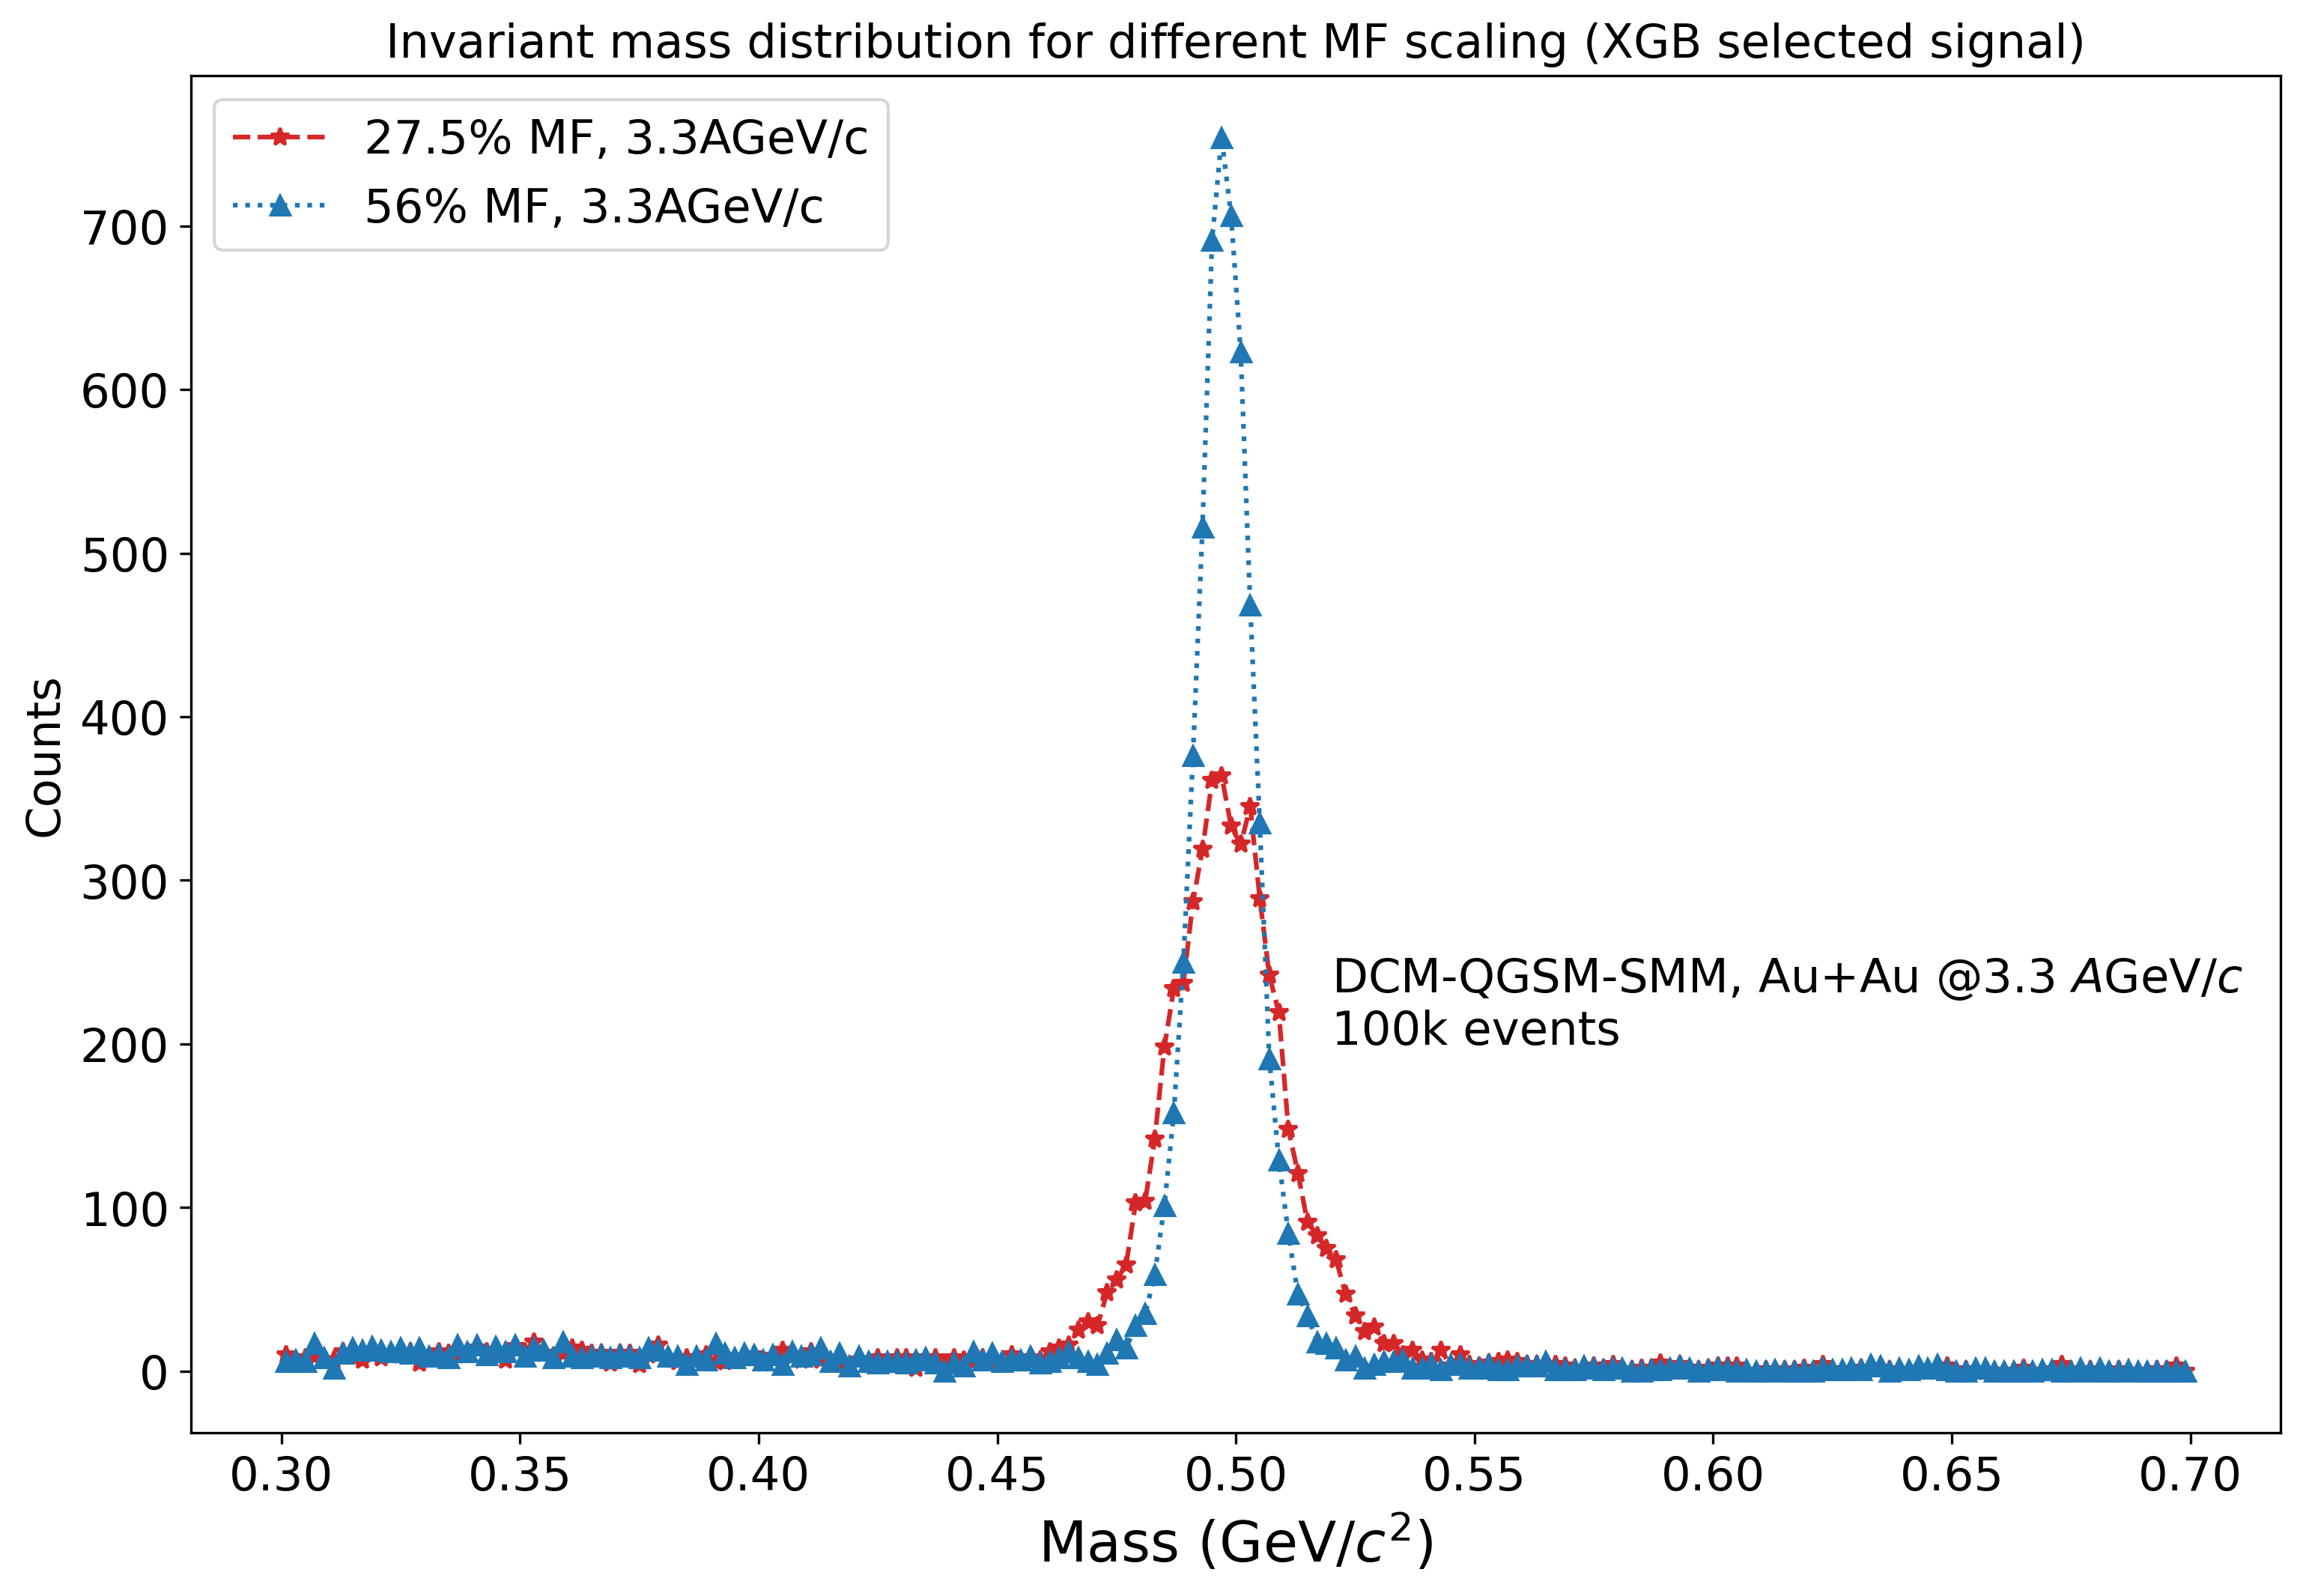

In [109]:
bins1 = 50
range1 = (0.3, 0.7)
fig, ax2 = plt.subplots(figsize=(12, 8), dpi = 300)
ax2.set_ylabel('Counts', fontsize = 15, color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)

# ax1 = ax2.twinx()
# ax1.set_xlabel('Mass in GeV', fontsize = 15)
# ax1.set_ylabel('Counts ', fontsize = 15, color=color2)
# ax1.tick_params(axis='y', labelcolor=color2)


def subplot(al, sign, marker, linestyle, label, color, color2):
#     counts, bin_edges = np.histogram(al['mass'],bins = bins1, range=range1)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
#     ax2.plot(bin_centers, counts, color=color, linestyle=linestyle, marker=marker, label=label)
    
    counts, bin_edges = np.histogram(sign['mass'],bins = 200, range=range1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax2.plot(bin_centers, counts, color=color2, linestyle=linestyle, marker=marker, label=label)

subplot(all27, sign27, marker='*', linestyle='dashed', label='27.5% MF, 3.3AGeV/c', color = 'tab:blue', color2 = 'tab:red')
subplot(all56, sign56, marker='^', linestyle='dotted', label='56% MF, 3.3AGeV/c', color = 'tab:cyan', color2 = 'tab:blue')

ax2.legend( fontsize = 15, loc='upper left')
# ax1.legend( fontsize = 15,loc='upper right' )
ax2.text(0.52, 200, r'DCM-QGSM-SMM, Au+Au @3.3 $A$GeV/$c$''\n100k events', fontsize=15)
plt.title("Invariant mass distribution for different MF scaling (XGB selected signal)", fontsize = 15)
#plt.text(0.02, 0.1, r'cut > %.4f'%cut, fontsize=15)
plt.show()
fig.tight_layout()
fig.savefig(directory+'img/mf_zoom.pdf')